<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Запрос" data-toc-modified-id="Запрос-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Запрос</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Создание дашборда по пользовательским событиям для агрегатора новостей

Менеджерам по анализу контента Яндекс. Дзен еженедельно необходима свежая информация о взаимодействии пользователей с карточками статей.

Каждую карточку в системе определяет ее тема и источник (у него тоже есть тема). Пользователи распределяются по возрастным категориям.

Для автоматизации процесса создадим дашборд.
Дашборд будет основываться на пайплайне, который будет брать данные из таблиц, хранящих сырые данные, трансформировать данные и укладывать их в агрегирующюю таблицу.

**Задачи данной работы:**

 - выгрузить информацию из базы данных в файл `csv`
 
 - используя файл сформировать дашборд в программе Tableau Public
 
 - ответить на вопросы менеджеров:
 

**Таким образом работа пройдет по следующим этапам:**

 - создадим коннекцию к базе
 - напишем код для выгрузки данных из таблицы `dash_visits` в файл `dash_visits.csv`
 - проверим данные

 - построим дашборд и постараемся ответить на вопросы менеджеров:

   - Cколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек? Исследуем абсолютные и относительные величины (% событий).
   - Как много карточек генерируют источники с разными темами? Исследуем относительные величины (% событий)
   - Как соотносятся темы карточек и темы источников?

**Подготовим презентацию с отчетом - ответы на вопросы и графики.**

## Запрос

 - Создадим запрос к базе данных и сохраним информацию в csv-файл

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import pandas as pd
from sqlalchemy import create_engine  # импортируем библиотеки

#!pip3 install psycopg2

In [2]:
# создадим коннекцию к базе

db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

In [3]:
query = '''                  
           SELECT *
           FROM dash_visits
        '''

log_raw = pd.io.sql.read_sql(query, con = engine)  # напишем sql-запрос

In [4]:
log_raw.to_csv('dash_visits.csv', index = False)
df = log_raw
df.head(5) 

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27


 - Изучим данные
 - Проверим столбцы

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB


In [6]:
print('Всего явных дубликатов: ', df.duplicated().sum())

Всего явных дубликатов:  0


In [7]:
print('Всего уникальных идентификаторов: ', df['record_id'].nunique())

Всего уникальных идентификаторов:  30745


In [8]:
for column in ['item_topic','source_topic','age_segment']: # проверим строковые столбцы
    print(df[column].value_counts())

Отношения             1536
Интересные факты      1535
Наука                 1505
Подборки              1456
Полезные советы       1424
Общество              1422
Россия                1385
История               1363
Семья                 1287
Путешествия           1247
Деньги                1234
Женщины               1230
Дети                  1229
Туризм                1206
Здоровье              1203
Красота               1193
Культура              1160
Юмор                  1129
Искусство             1119
Рассказы              1109
Психология            1056
Скандалы              1023
Знаменитости           976
Женская психология     914
Шоу                    804
Name: item_topic, dtype: int64
Семейные отношения    1822
Россия                1687
Знаменитости          1650
Полезные советы       1578
Путешествия           1563
Кино                  1505
Дети                  1459
История               1437
Семья                 1405
Одежда                1379
Здоровье              12

In [9]:
print('Максимальная дата: {}'.format( df['dt'].max()))  # изучим столбец с датами
print('')
print('Минимальная дата: {}'.format(df['dt'].min()))
print('')
print('Период для данных: {}'.format(df['dt'].max() - df['dt'].min()))

Максимальная дата: 2019-09-24 19:00:00

Минимальная дата: 2019-09-24 18:28:00

Период для данных: 0 days 00:32:00


In [10]:
df['dt'].sort_values().unique()

array(['2019-09-24T18:28:00.000000000', '2019-09-24T18:29:00.000000000',
       '2019-09-24T18:30:00.000000000', '2019-09-24T18:31:00.000000000',
       '2019-09-24T18:32:00.000000000', '2019-09-24T18:33:00.000000000',
       '2019-09-24T18:34:00.000000000', '2019-09-24T18:35:00.000000000',
       '2019-09-24T18:52:00.000000000', '2019-09-24T18:53:00.000000000',
       '2019-09-24T18:54:00.000000000', '2019-09-24T18:55:00.000000000',
       '2019-09-24T18:56:00.000000000', '2019-09-24T18:57:00.000000000',
       '2019-09-24T18:58:00.000000000', '2019-09-24T18:59:00.000000000',
       '2019-09-24T19:00:00.000000000'], dtype='datetime64[ns]')

*Комментарий* 

Анализируем небольшой временной период в 30 минут, 17 уникальных значений временных отметок

In [11]:
df['visits'].describe()   # изучим как распределяются визиты

count    30745.000000
mean        10.089673
std         19.727601
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        371.000000
Name: visits, dtype: float64

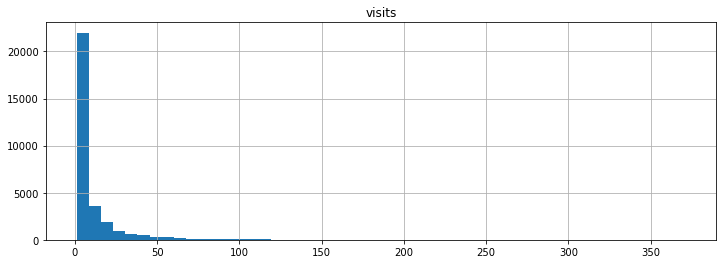

In [12]:
df.hist('visits', bins=50, figsize=(12,4));

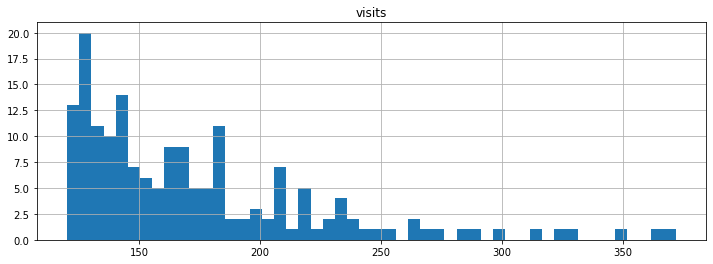

In [13]:
df.hist('visits', bins=50, figsize=(12,4), range=(120,372));

*Комментарий*

 - В столбце `visits` есть выбросы до 371. Подавляющее большинство значений расположено от 1 до 25.

## Вывод

 - В таблице 6 столбцов. Количество строк во всех столбцах одинаковое, значит пропусков нет.
 - Тип данных для всех столбцов соответствующий.
 - Все идентификаторы уникальны. Число идентификаторов равно числу строк в таблице
 - Дубликатов не выявили.
 - В описании строковых столбцов аномалий не выявили
  
**Все табличные данные в порядке. Изменнений и корректировок не вносим. Используем выгруженый файл  `dash_visits.csv` для создания дашборда в Tableau Public**

[Ссылка на публикацию дашборда в Tableau Public](https://public.tableau.com/views/VisitsDashboard_16574803945030/sheet4?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)